In [1]:
import os
import time
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

from algorithms.utils import read_input, write_solution
from algorithms.tabu_search import tabu_search, calculate_cost

In [2]:
# Paths
input_file = "data/instances/i02.json"
output_file = "data/output_solutions/out_sol_test02.json"
log_file = "./performance_log.csv"

# Ensure output folder exists
os.makedirs("./data/output_solutions", exist_ok=True)

# Initialize performance log
performance_log = []

# Step 1: Load Input Data
print(f"Processing {input_file}...")
data = read_input(input_file)

# Step 2: Run Tabu Search
start_time = time.time()
best_solution, cost_history = tabu_search(data, iterations=20, tabu_tenure=10)
end_time = time.time()

# Step 3: Calculate Final Cost
final_cost = calculate_cost(best_solution, data)

# Step 4: Save Solution
write_solution(output_file, best_solution)

# Step 5: Log Performance
performance_log.append({
    "instance": os.path.basename(input_file),
    "final_cost": final_cost,
    "execution_time": round(end_time - start_time, 2)
})

# Save log to CSV
df_log = pd.DataFrame(performance_log)
if os.path.exists(log_file):
    df_log.to_csv(log_file, mode='a', index=False, header=False)
else:
    df_log.to_csv(log_file, index=False, header=True)

print(f"Completed {input_file}: Cost = {final_cost}, Time = {round(end_time - start_time, 2)}s")
print(f"Solution saved to: {output_file}\n")

# Step 6: Run Validator Command
print("Running Validator...")
violations = {}
costs = {}
try:
    result = subprocess.run(
        ["./IHTP_Validator", input_file, output_file, "verbose"],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        check=True
    )
    print("Validator Output:")
    print(result.stdout)

    # Parse violations from validator output
    parsing_costs = False  # Track whether we are parsing the COSTS section
    for line in result.stdout.splitlines():
        if "VIOLATIONS:" in line:
            continue  # Skip the heading for violations
        if "COSTS" in line:
            parsing_costs = True  # Start parsing costs
            continue
        if "Total violations" in line or "Total cost" in line:
            continue  # Skip total lines
        if "...." in line and not parsing_costs:  # Parse violations
            parts = line.split("....", maxsplit=1)  # Split at the first set of dots
            if len(parts) == 2:
                key = parts[0].strip()  # Extract the violation name
                value_part = parts[1].strip()  # Extract the value part
                try:
                    # Extract only digits from the value
                    value = int(''.join(filter(str.isdigit, value_part)))
                    violations[key] = value
                except ValueError:
                    print(f"Warning: Could not parse value for {key} -> {value_part}")
        elif parsing_costs and "..." in line:  # Parse costs
            parts = line.split("...", maxsplit=1)  # Split at the first set of dots
            if len(parts) == 2:
                key = parts[0].strip()  # Extract the cost name
                value_part = parts[1].strip()  # Extract the value part
                try:
                    # Extract only digits from the value
                    value = int(''.join(filter(str.isdigit, value_part.split("(")[0])))
                    costs[key] = value
                except ValueError:
                    print(f"Warning: Could not parse value for {key} -> {value_part}")


except subprocess.CalledProcessError as e:
    print("Error running validator:")
    print(e.stderr)

Processing data/instances/i02.json...
Iteration 0: Cost = 4243165
Iteration 1: Cost = 3640196
Iteration 2: Cost = 3040246
Iteration 3: Cost = 2440331
Iteration 4: Cost = 1841342
Iteration 5: Cost = 1390323
Iteration 6: Cost = 940274
Iteration 7: Cost = 632265
Iteration 8: Cost = 328283
Iteration 9: Cost = 26314
Iteration 10: Cost = 22315
Iteration 11: Cost = 19317
Iteration 12: Cost = 16347
Iteration 13: Cost = 14348
Iteration 14: Cost = 12359
Iteration 15: Cost = 11328
Iteration 16: Cost = 10327
Iteration 17: Cost = 9332
Iteration 18: Cost = 8331
Iteration 19: Cost = 7258
Completed data/instances/i02.json: Cost = 7258, Time = 505.19s
Solution saved to: data/output_solutions/out_sol_test02.json

Running Validator...
Validator Output:
Room r1 is gender-mixed 2/1 on day 4
Room r1 is gender-mixed 2/1 on day 5
Room r2 is gender-mixed 1/1 on day 1
Room r2 is gender-mixed 1/2 on day 2
Room r2 is gender-mixed 2/1 on day 3
Room r4 is gender-mixed 2/1 on day 2
Room r4 is gender-mixed 2/3 on day

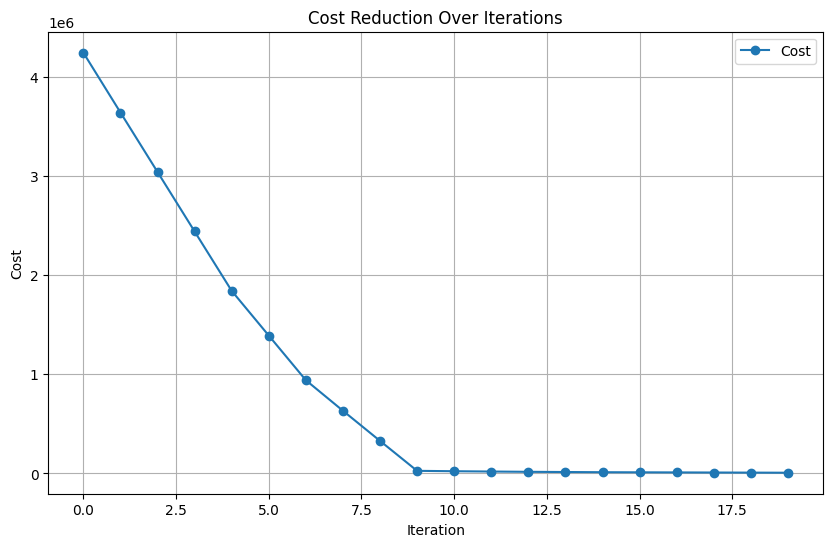

In [3]:
def plot_cost_reduction(costs):
    plt.figure(figsize=(10, 6))
    plt.plot(costs, marker='o', label="Cost")
    plt.title("Cost Reduction Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.grid()
    plt.legend()
    plt.show()

plot_cost_reduction(cost_history)

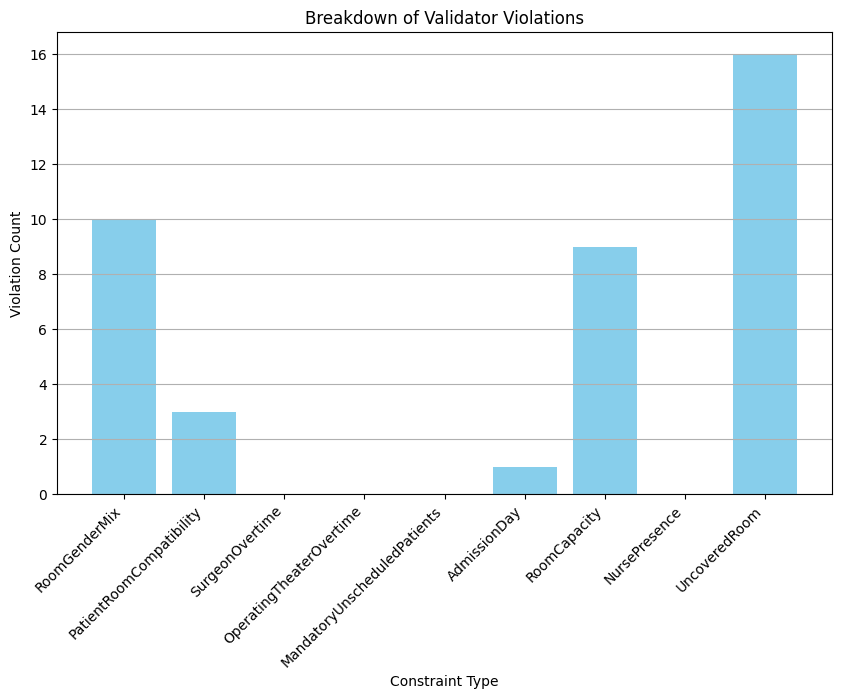

In [4]:
def plot_violations(violations):
    keys = list(violations.keys())
    values = list(violations.values())

    plt.figure(figsize=(10, 6))
    plt.bar(keys, values, color='skyblue')
    plt.title("Breakdown of Validator Violations")
    plt.xlabel("Constraint Type")
    plt.ylabel("Violation Count")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y')
    plt.show()

plot_violations(violations)